<h1 style='text-align: center'>
    <span style='color: red; font-weight: 700'>Advanced Binning features for selection</span> </h1>

<p  style='text-align: center'>
    
In this notebook I prepare advanced function called "binning" for features selection based on Information Value.
I haven been talking in my <a href='https://www.kaggle.com/code/kobzetsu/top-25-most-important-features-using-gini-iv-woe'> notebook </a> about features selection using Gini, IV, WOE. In my privous notebook I use "qcut" for bin continous feature into some parts, but this is an easy way. For selection features with high IV it is correct to use the algorithm based on Decision Tree described in this notebook.

In [67]:
from sklearn.datasets import load_breast_cancer
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch.autograd import Variable

from sklearn.metrics import roc_auc_score
import itertools

from sklearn import tree
import math

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rc("font", size=14)

In [68]:
data = pd.read_csv('train.csv').fillna(0)

In [69]:
variables = [col for col in data if col not in ['failure', 'id'] and data[col].dtypes != 'O']

In [70]:
def iv_for_var(data):
    
    data['share'] = data['all_cnt'] / data['all_cnt'].sum()
    data['distribution_of_good'] = data['target_cnt'] / data['target_cnt'].sum()
    data['distribution_of_bad'] = (data['all_cnt'] - data['target_cnt']) / (data['all_cnt'].sum() - data['target_cnt'].sum())
    data['woe'] = np.log(data['distribution_of_good'] / data['distribution_of_bad'])

    data['iv'] = data['woe'] * (data['distribution_of_good'] - data['distribution_of_bad'])
    
    return data['iv'].sum()

def WOE(gap_bads, bads, gap_goods, goods):
    bads_share = (len(gap_bads) + 0.5) / (len(bads) + 0.5) * 1.0
    goods_share = (len(gap_goods) + 0.5) / (len(goods) + 0.5) * 1.0
    val = (goods_share / bads_share)
    return math.log(val), goods_share, bads_share

In [71]:
def binning(x, y, power_depth=20, leaf=2000):
    
    best_iv = 0
      
    alldf = pd.concat([x, y], axis=1)
    
    data_goods = alldf[y == 1]
    data_bads = alldf[y == 0]
    
    for depth in range(1, power_depth + 1):
    
        dt = tree.DecisionTreeClassifier(criterion="entropy",
                                 splitter="best" ,max_depth=depth,
                                 min_samples_leaf=leaf)

        dt.fit(x[:, None], y)
        
        limit = 10000000
        #  threshold values at nodes without double and leaf value -2 
        threshold = list(np.unique([x for x in dt.tree_.threshold if x != -2]))

        # Adding an upper and lower limit
        threshold.append(limit)
        threshold.append(limit * -1)
        # sort 
        threshold.sort()
        # prepare gaps with limits
        gaps = []
        for i in range(len(threshold) - 1):
            gaps.append([threshold[i], threshold[i + 1]])
            
        # calculate WOE for gaps
        woe = 0
        gaps_shares = []
        gaps_woe = []
        
        data_good = alldf[alldf['y'] == 1]
        data_bad = alldf[alldf['y'] == 0]

        # for each gap
        for gap in gaps:
            # upper and lower limit 
            limlow = gap[0]
            limhigh = gap[1]
            # наблюдения в сегменте
            gap_data = alldf[(alldf['x'] >= limlow) & (alldf['x'] <= limhigh)]
            # Goods
            gap_goods = gap_data[gap_data['y'] == 1]
            # Bads
            gap_bads = gap_data[gap_data['y'] == 0]


            # woe for gap
            woe, gap_goods_share, gap_bads_share = WOE(gap_goods, data_good, gap_bads, data_bad)
            # woe for bin
            gaps_shares.append([gap_goods_share, gap_bads_share])
            gaps_woe.append(woe)
        
        # iv for var bin
        ivs = [(gs[0] - gs[1]) * gw for gs, gw in zip(gaps_shares, gaps_woe)]
        iv = np.sum(ivs)
        
        # save best bin
        if iv > best_iv:
            best_gaps = gaps
            best_gaps_shares = gaps_shares
            best_gaps_woe = gaps_woe
            best_iv = iv

    return best_iv

In [72]:
vars_to_bin = data[variables].nunique()
vars_to_bin = vars_to_bin[vars_to_bin > 10].index

# qcut

In [78]:
# method using qcut

In [73]:
vars_iv_qcut = pd.DataFrame(columns=['variable','iv_by_qcut'])


for var in variables:
    if var in vars_to_bin:
        var_bin = pd.qcut(data[var], q=15, duplicates='drop') # Bin it into 15 parts
    else:
        var_bin = data[var]
        
    df_var_bin = pd.DataFrame({'bucket': var_bin, 'target': data['failure']})
    
    var_bin_grp = df_var_bin.groupby(['bucket']).agg({'bucket':'count','target':'sum'}).rename(
    columns={'bucket':'all_cnt', 'target':'target_cnt'}
        ).reset_index(level=0)
    
    var_iv = iv_for_var(var_bin_grp)
    vars_iv_qcut = vars_iv_qcut.append(
        pd.DataFrame([[var,var_iv]], columns=['variable','iv_by_qcut']), ignore_index = True)
    
vars_iv_qcut.sort_values(by='iv_by_qcut',ascending=False).head(5)

,variable,iv_by_qcut
0,loading,0.096396
20,measurement_17,0.007001
9,measurement_6,0.005213
5,measurement_2,0.004812
8,measurement_5,0.004488


# Binning

In [77]:
# method using binning

In [74]:
vars_iv_tree = pd.DataFrame(columns=['variable','iv_by_tree'])


for var_ in variables:
    x = data[var_].copy()
    y = data['failure'].copy()
    x.rename("x", inplace=True)
    y.rename("y", inplace=True)
    
    var_iv = binning(x, y)
    vars_iv_tree = vars_iv_tree.append(
        pd.DataFrame([[var_,var_iv]], columns=['variable','iv_by_tree']), ignore_index = True)
    
vars_iv_tree.sort_values(by='iv_by_tree',ascending=False).head(5)

,variable,iv_by_tree
0,loading,0.101371
20,measurement_17,0.011307
9,measurement_6,0.010716
8,measurement_5,0.007021
15,measurement_12,0.006452


# Сomparison of results

In [75]:
vars_iv = vars_iv_qcut.merge(vars_iv_tree, on='variable')

<Figure size 1440x1800 with 0 Axes>

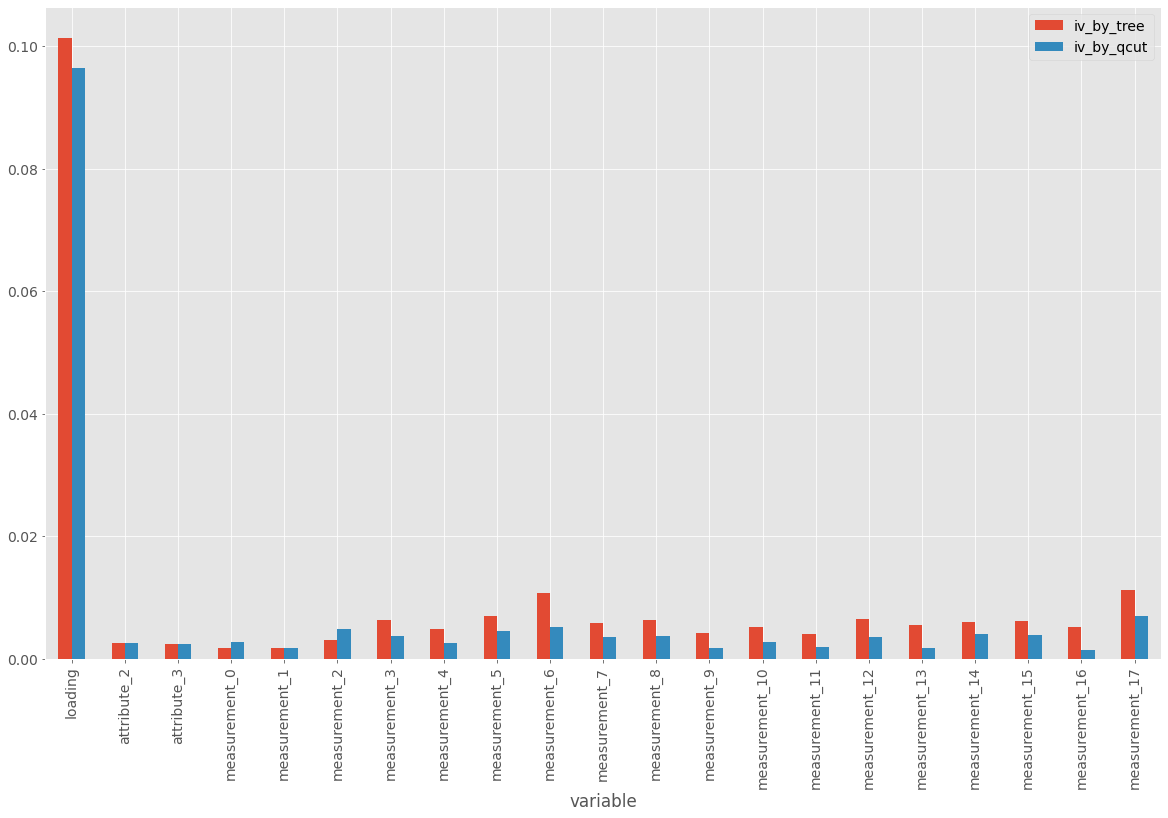

In [76]:
plt.figure(figsize=(20,25))
vars_iv.plot(x="variable", y=["iv_by_tree",'iv_by_qcut'], kind='bar',figsize=(20,12))
plt.show()

Now we can see the difference between the approaches. Using binning, we will select another set of features for the model that will be more informative